### Test Corr Models

In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy
import yfinance as yf

import dynamic_correlations as CM
import expected_shortfall as ES
import backtesting as BT
import plots as IP

In [2]:
# Step 1: Download prices
tickers = ["^GSPC", "^STOXX50E", "^N225"]
data = yf.download(tickers, start="2020-01-01", end="2023-01-01")["Close"]
data = data.dropna()

# Step 2: Define fixed quantities
quantities = pd.Series([10, 20, 30], index=tickers)

# Step 3: Compute monetary positions
x_matrix = data.multiply(quantities, axis=1)


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  3 of 3 completed


In [3]:
x_matrix.head()

,^GSPC,^N225,^STOXX50E
Date,,,
2020-01-06,32462.800293,696145.781250,75050.400391
2020-01-07,32371.799316,707271.621094,75185.000000
2020-01-08,32530.500488,696142.792969,75451.201172
2020-01-09,32746.999512,712196.074219,75917.597656
2020-01-10,32653.500977,715517.109375,75790.400391


In [4]:
32462.800293 + 696145.781250 + 75050.400391

803658.9819339999

In [5]:
# Run MA Correlation VaR
x_ma = deepcopy(x_matrix)
result_ma, next_day_ma = CM.var_corr_ma(x_ma, window_size=20)

# Run RiskMetrics Correlation VaR
x_rm = deepcopy(x_matrix)
result_rm, next_day_rm = CM.var_corr_riskmetrics(x_rm)


In [6]:
print("== MA Correlation VaR ==")
print(result_ma[["Returns", "Volatility", "VaR", "VaR Monetary", "VaR Violation"]].head())
print("Next-day MA VaR (monetary):", round(next_day_ma, 2), "\n")

print("== RiskMetrics Correlation VaR ==")
print(result_rm[["Returns", "Volatility", "VaR", "VaR Monetary", "VaR Violation"]].head())
print("Next-day RM VaR (monetary):", round(next_day_rm, 2))


== MA Correlation VaR ==
             Returns  Volatility       VaR  VaR Monetary  VaR Violation
2020-02-05  0.010412    0.010385  0.024529  19831.752291          False
2020-02-06  0.021416    0.011014  0.026015  21482.292955          False
2020-02-07 -0.002046    0.010565  0.024954  20564.541652          False
2020-02-10 -0.004994    0.009584  0.022636  18560.937834          False
2020-02-12  0.008245    0.009722  0.022963  18983.843638          False
Next-day MA VaR (monetary): 17401.86 

== RiskMetrics Correlation VaR ==
             Returns  Volatility       VaR  VaR Monetary  VaR Violation
Date                                                                   
2020-01-07  0.013927    0.013177  0.029399  23955.327952          False
2020-01-08 -0.013091    0.013158  0.029356  23606.011674          False
2020-01-09  0.020845    0.013753  0.030685  25188.120210          False
2020-01-10  0.003782    0.013373  0.029836  24583.341420          False
2020-01-14  0.006228    0.013061  0.02


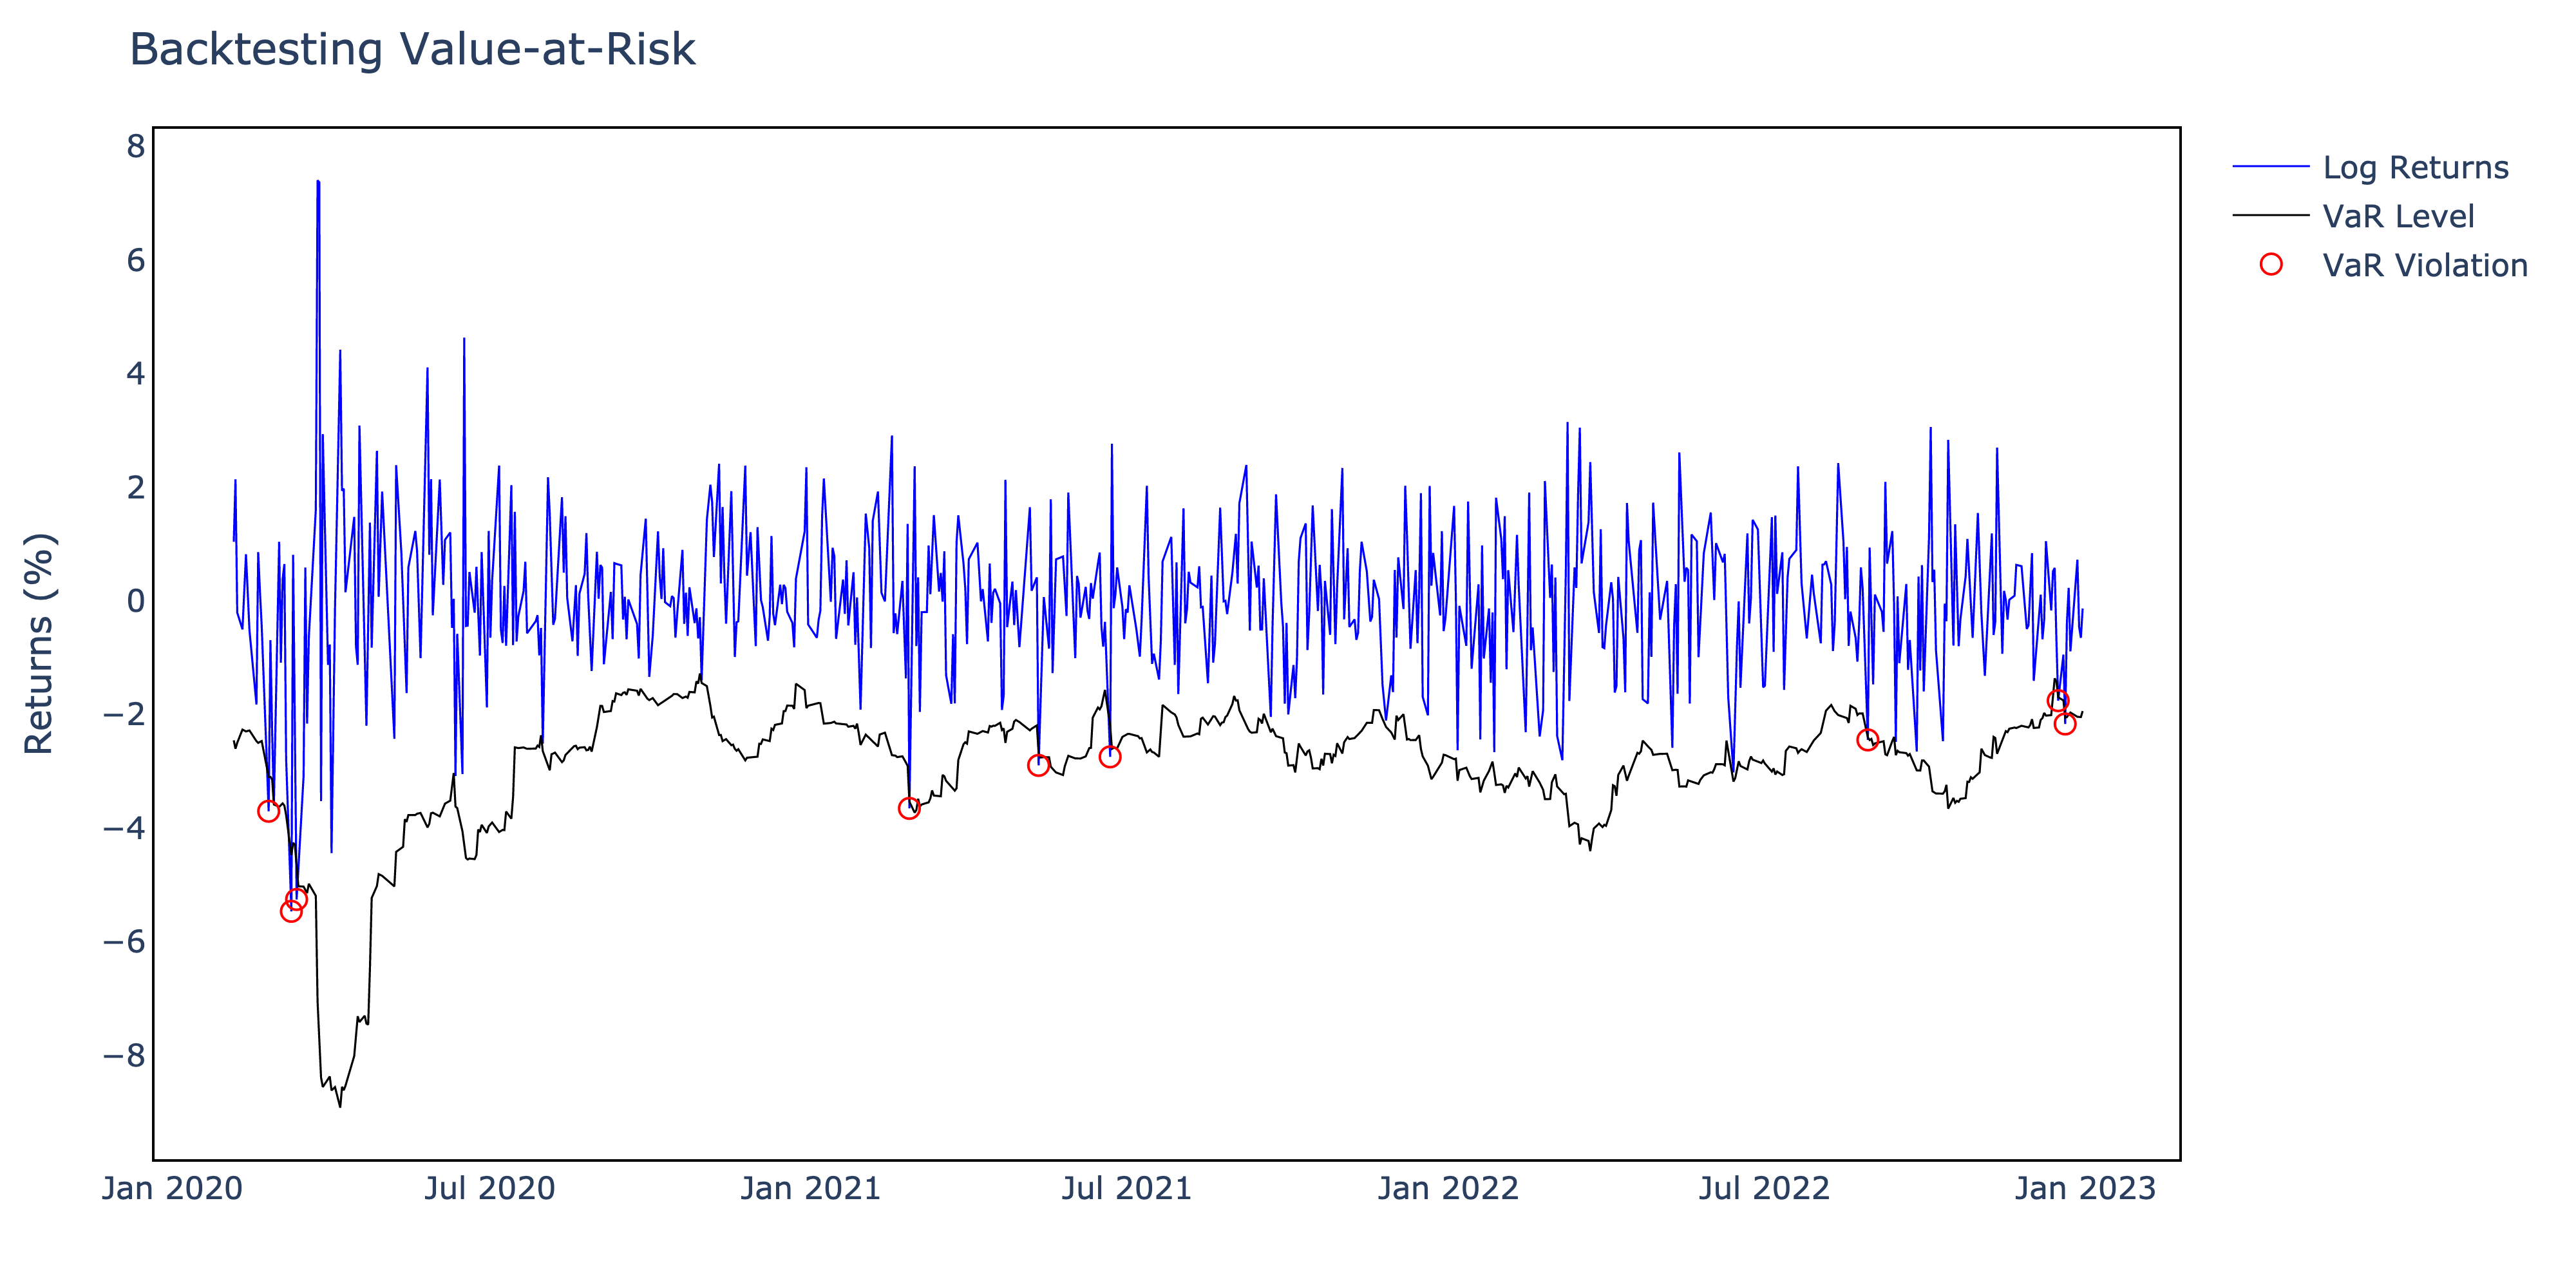


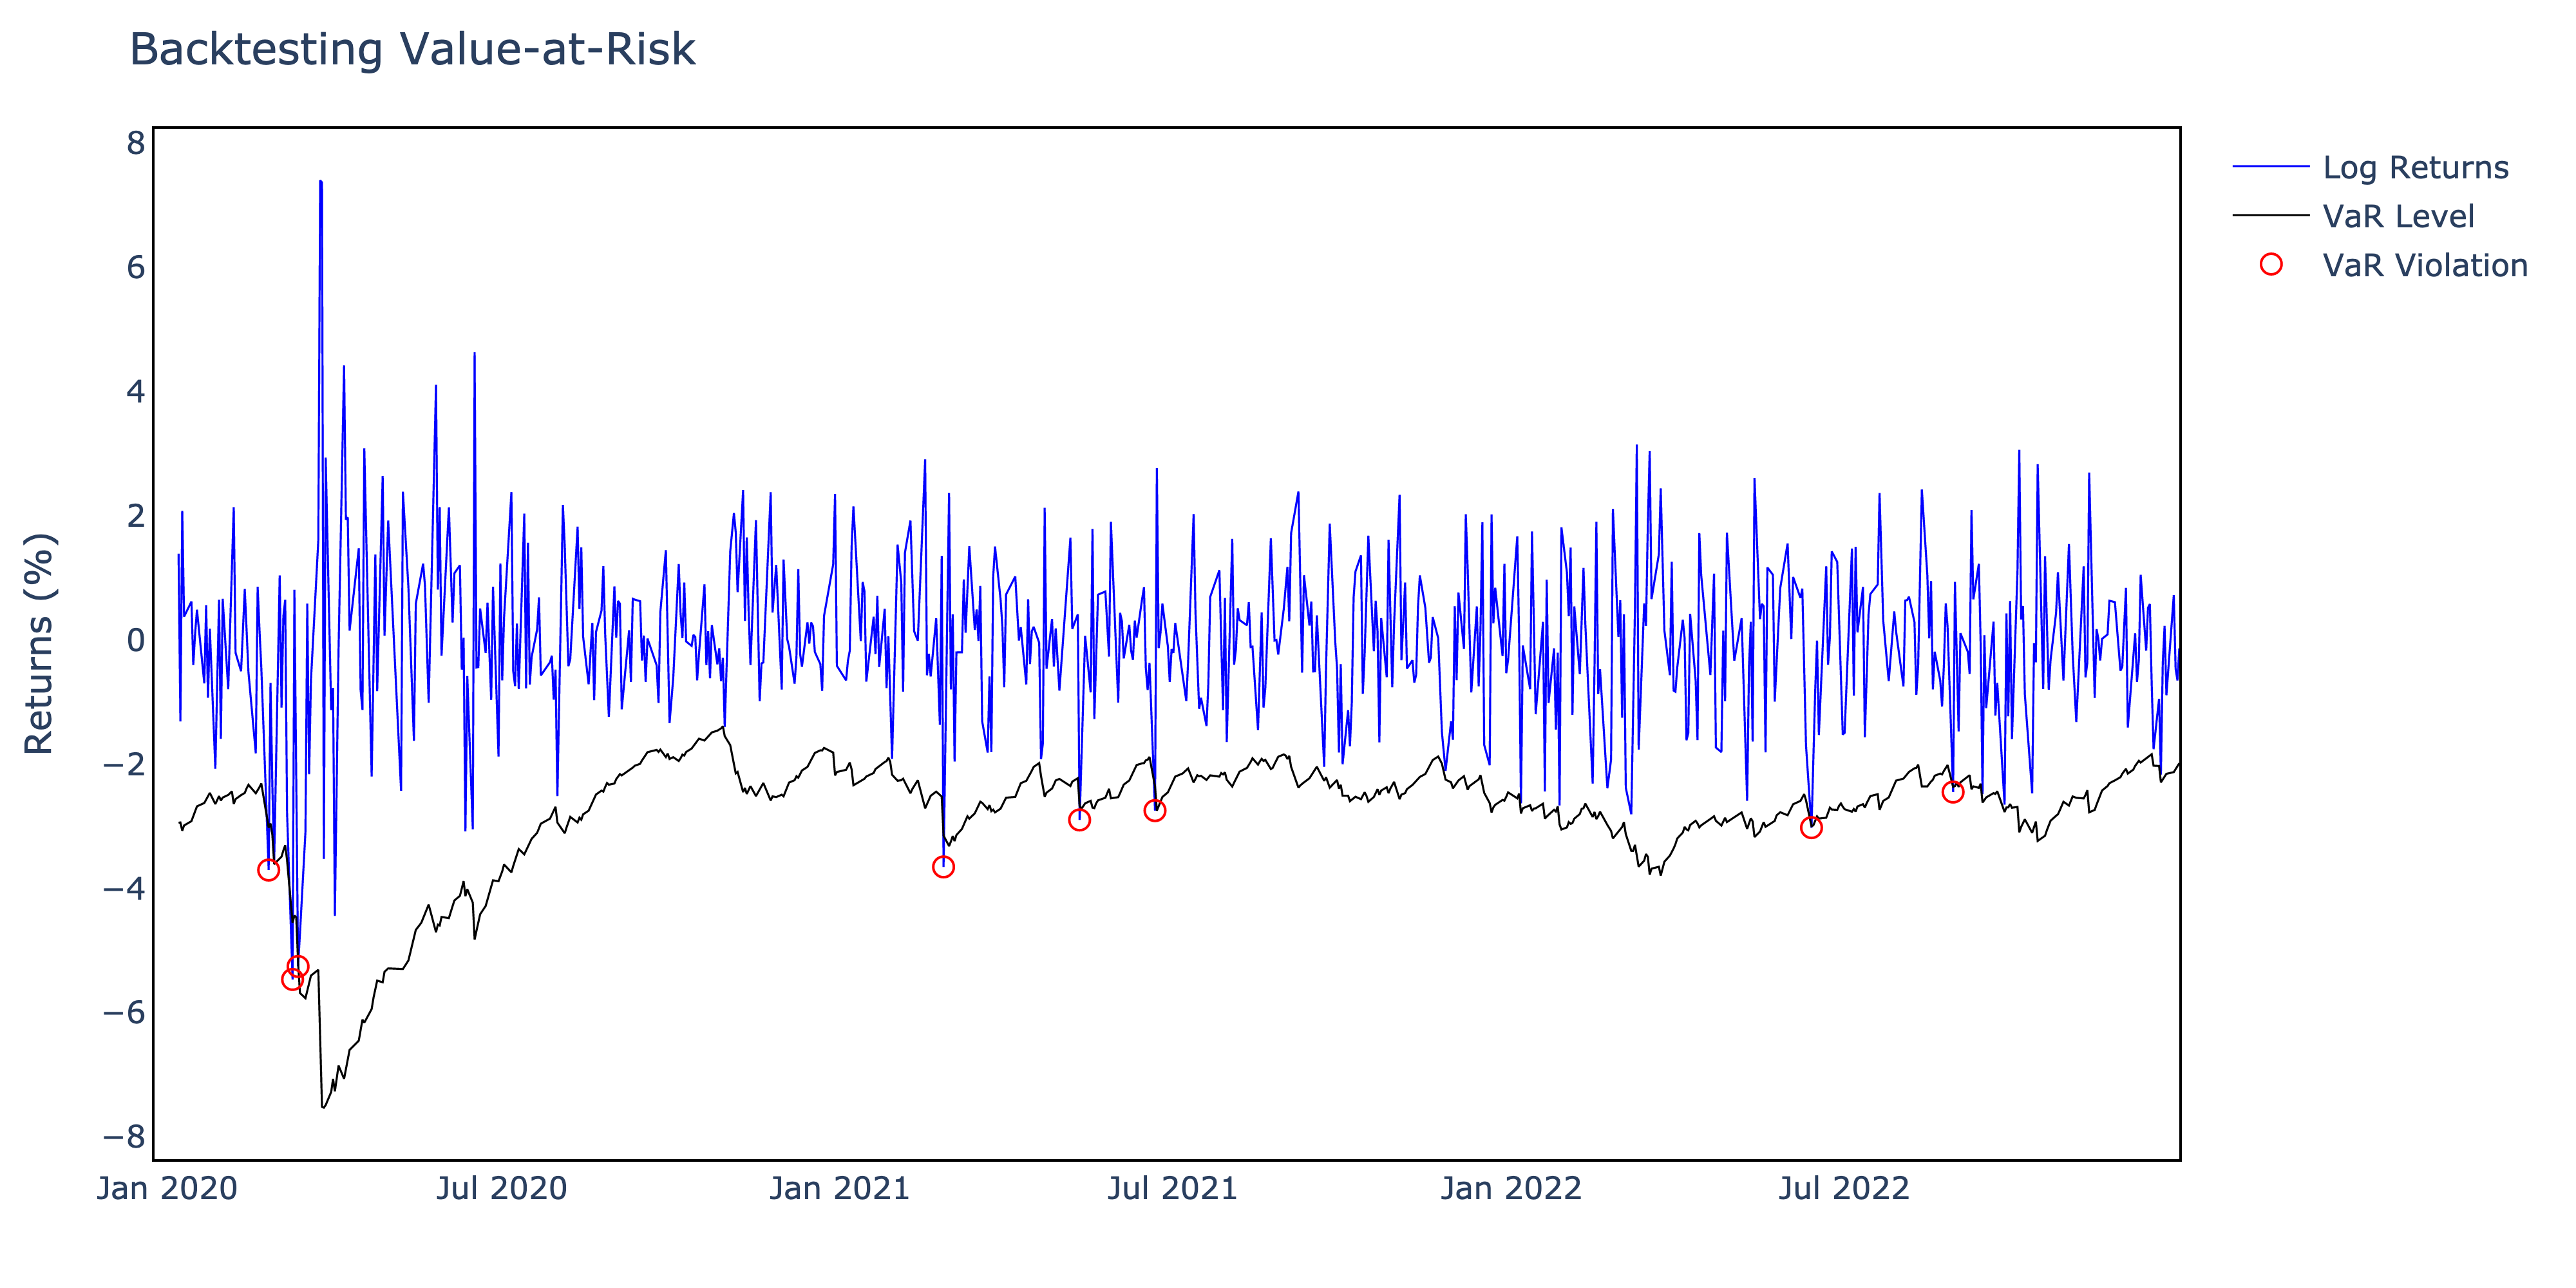

In [7]:
# Just call the function on either result:
fig_ma = IP.plot_var(result_ma, interactive=False)

# Or for RiskMetrics:
fig_rm = IP.plot_var(result_rm, interactive=False)


In [8]:
# Apply volatility-based ES to the MA VaR result
result_ma = ES.compute_expected_shortfall_correlation(result_ma, confidence_level=0.99)

# Same for RiskMetrics
result_rm = ES.compute_expected_shortfall_correlation(result_rm, confidence_level=0.99)


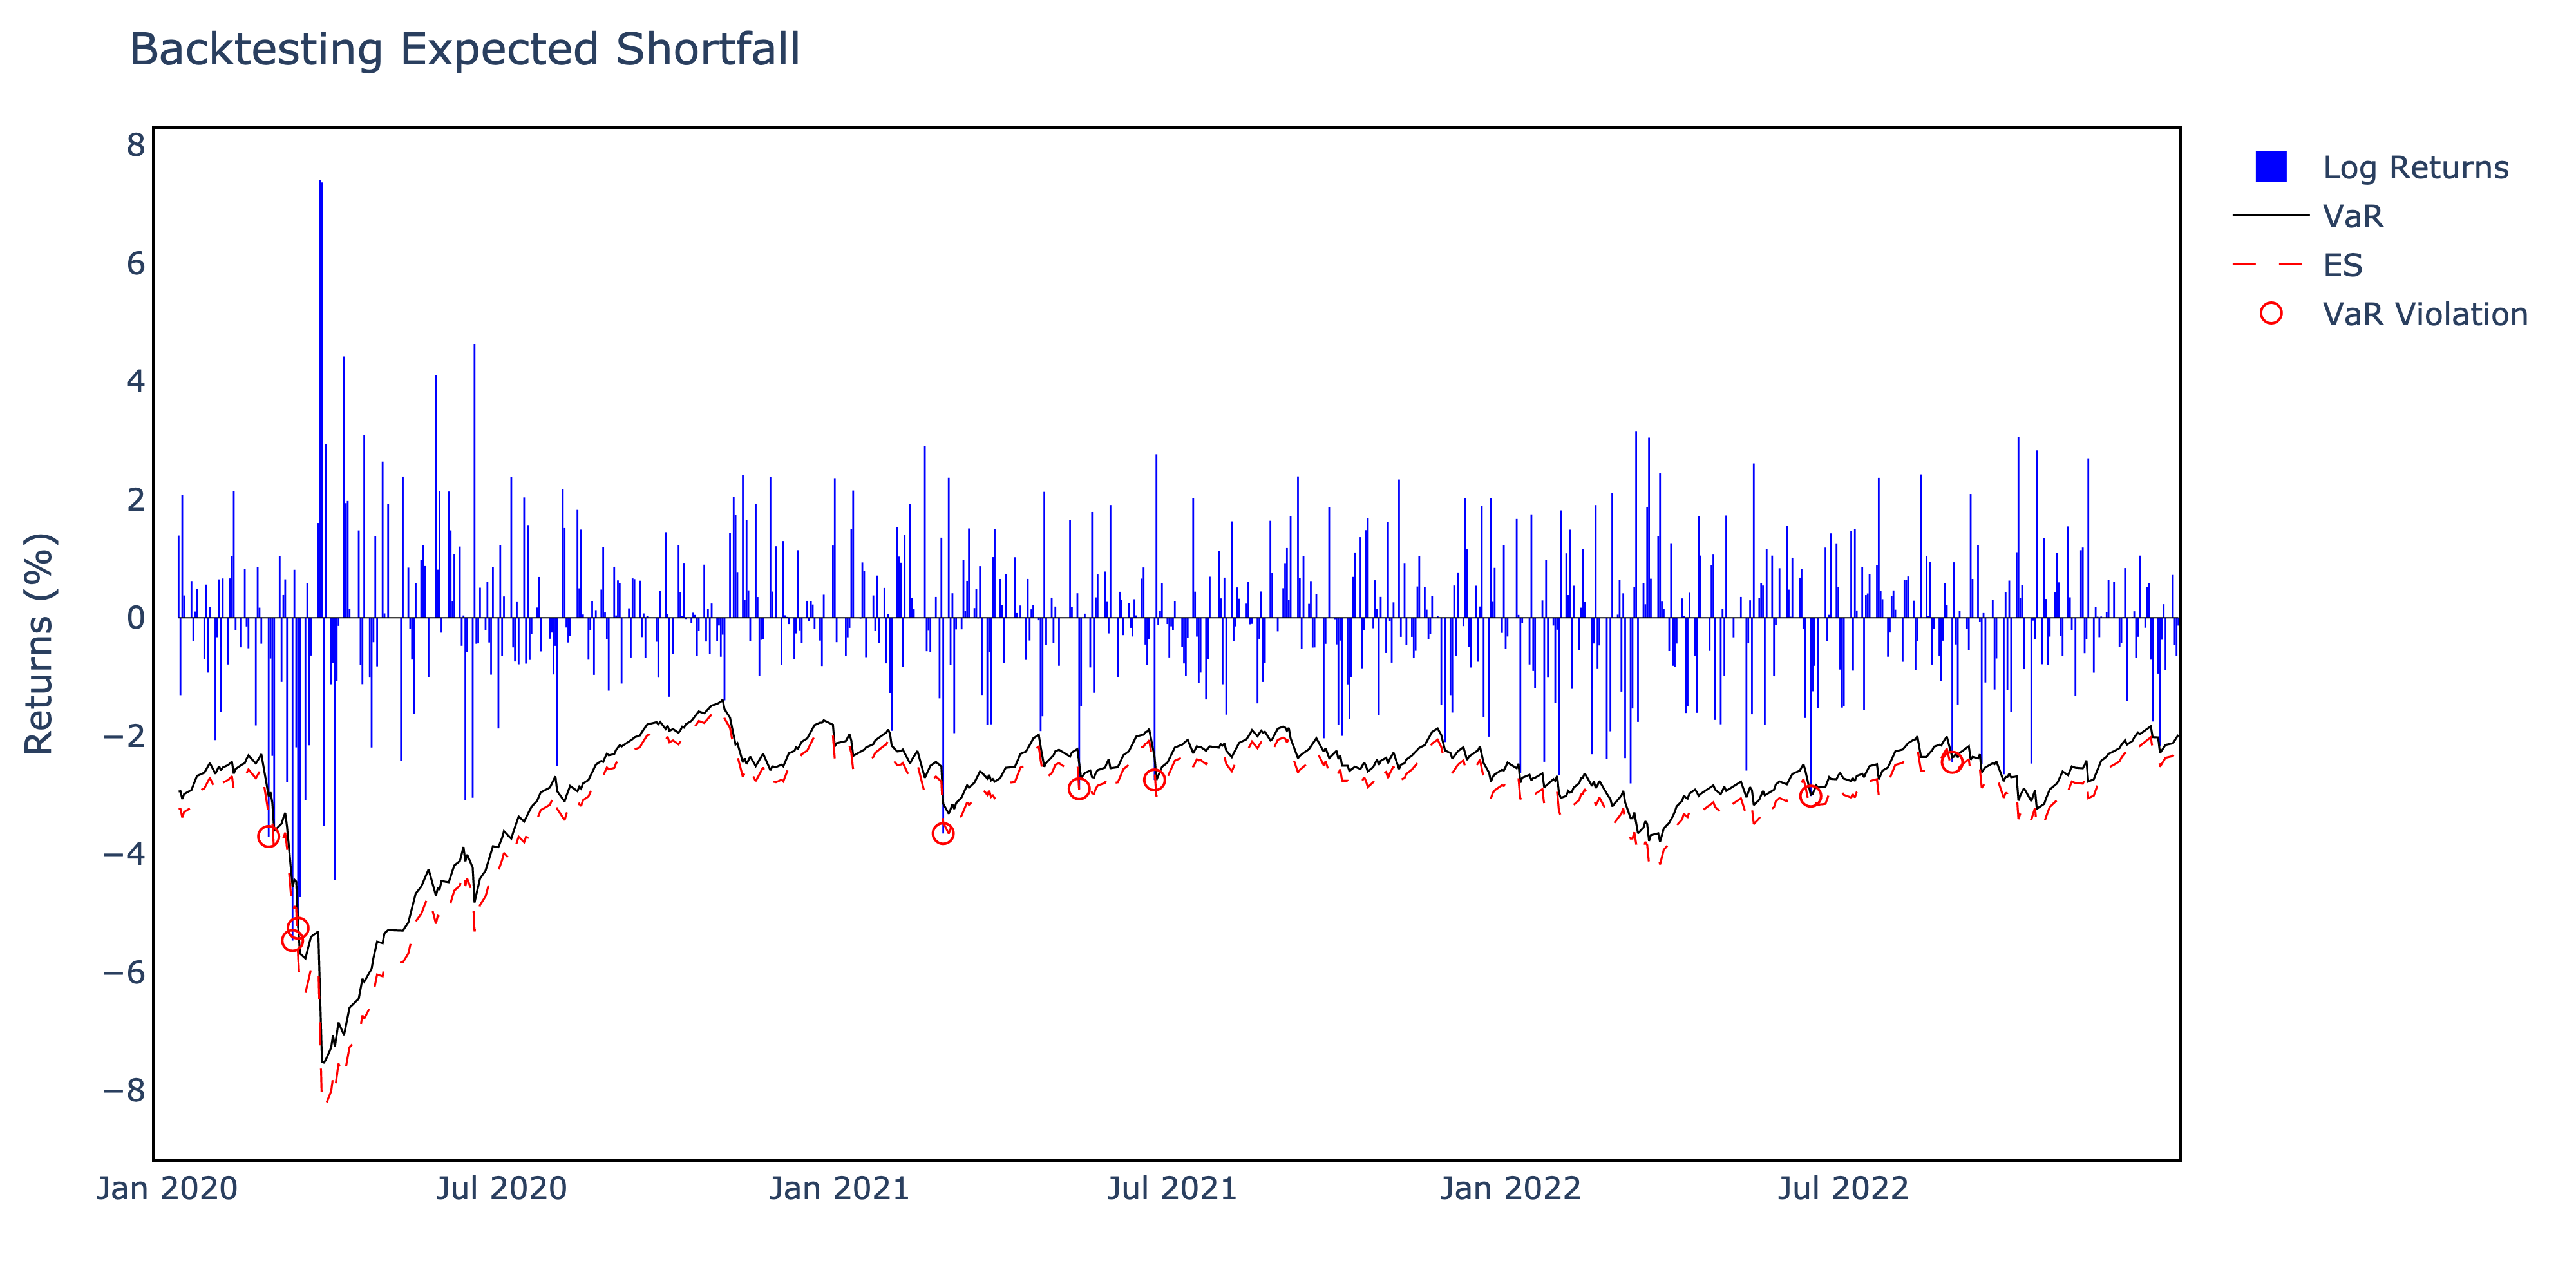

In [15]:
# Plot MA model results
fig_ma_es = IP.plot_es(result_ma, interactive=True)

# Plot RiskMetrics model results
fig_rm_es = IP.plot_es(result_rm, interactive=False)

In [10]:
result_ma.head()

,Returns,Volatility,Innovations,VaR,VaR Monetary,VaR Violation,ES,ES Monetary
2020-02-05,0.010412,0.010385,0.642340,0.024529,19831.752291,False,0.026955,21793.205801
2020-02-06,0.021416,0.011014,0.945361,0.026015,21482.292955,False,0.028588,23606.992694
2020-02-07,-0.002046,0.010565,2.026992,0.024954,20564.541652,False,0.027422,22598.471473
2020-02-10,-0.004994,0.009584,-0.213439,0.022636,18560.937834,False,0.024875,20396.701821
2020-02-12,0.008245,0.009722,-0.513694,0.022963,18983.843638,False,0.025234,20861.434997


In [11]:
violations_ma, rate_ma = BT.backtest_var(result_ma, confidence_level=0.99)

print("== MA Correlation VaR Backtest ==")
print(f"Total Violations: {violations_ma}")
print(f"Violation Rate: {rate_ma:.2f}%")

== MA Correlation VaR Backtest ==
Total Violations: 9
Violation Rate: 1.34%


In [12]:
violations_rm, rate_rm = BT.backtest_var(result_rm, confidence_level=0.99)

print("== RiskMetrics Correlation VaR Backtest ==")
print(f"Total Violations: {violations_rm}")
print(f"Violation Rate: {rate_rm:.2f}%")

== RiskMetrics Correlation VaR Backtest ==
Total Violations: 8
Violation Rate: 1.15%


In [13]:
fig_ma_vol = IP.plot_volatility(result_ma["Volatility"])
fig_rm_vol = IP.plot_volatility(result_rm["Volatility"])